In [2]:
import cv2
import numpy as np
import time
from skimage.io import imshow,imread,imsave
from scipy import ndimage as ndi
from skimage import feature
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from skimage.morphology import square,dilation


In [3]:
##--------------- find white,yellow pixel of lane (first) -------------------#
# def findWhitePixel(image,height,p_count):
#     y1 = []
#     p1 = 0
#     counter = 0
#     start=p_count
#     for pixel in image[height:height+1]:
#         for j in range (int(pixel.shape[0]/2)): 
#             if pixel[j+start] == 255:
#                 if counter == 0:
#                     p1 = p_count
#                     break         
#             p_count += 1
#         if p1 == 0:
#               return False
#         else:            
#             y1 = (p1,height)
#             return y1

#--------------- find white,yellow pixel of lane -------------------#
def findWhitePixel(image,height,p_count):
    y1 = y2 = []
    p1 = p2 = 0
    counter = 0
    start=p_count
    for pixel in image[height:height+1]:
        for j in range (int(pixel.shape[0]/2)): 
            if counter == 2:
                break
            if pixel[j+start] == 255 and counter == 0:
                p1 = p_count
                counter += 1
            if pixel[j+start] == 0 and counter == 1:
                p2 = p_count
                counter += 1            
            p_count += 1
        if p1 == 0 and p2 == 0:
              return False
        else: 
#             print("p1,p2   : ",(p1,p2))
            y1 = (int((p1+p2) / 2),height)
            return y1

#--------------- find slope of lane -------------------#
def slope(start,end,width):
    x1=start[0]
    x2=end[0]

    y1=width-start[1]
    y2=width-end[1]
    if(x2-x1!=0):
        m=(y2-y1)/(x2-x1)
        return m
    

In [4]:
def region_of_interest(img, vertices):
    
    mask = np.zeros_like(img)
    match_mask_color = (255,)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def save_image(img,name):
    imsave('./dataset/'+str(name)+'.jpg',img)

In [5]:
url='../video/test.h264'
cap = cv2.VideoCapture(url)
count=0
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    frame = cv2.resize(frame,(640, 480))
    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
#     if(count%2==0):

    height=frame.shape[0]
    width=frame.shape[1]
    region_of_interest_vertices = [   
        (0, height),
        (0, (height/3)),
    #     ((width/5), (height/3)),

    #     (width-(width/5), (height/3)),
        (width, (height/3)),
        (width, height)]


    lowerB=np.array([50,50,50])
    upperB=np.array([170,170,170])    
    maskB = cv2.inRange(frame, lowerB, upperB)

    cropped_image = region_of_interest(maskB,np.array([region_of_interest_vertices], np.int32))
    cropped_image[int(height/3):int(height/3)+5,100:width-101]=255
    cropped_image[height-1,:]=255
    cropped_image[:,0:2]=255
    cropped_image[:,width-6:]=255

    binary = np.array(ndi.binary_fill_holes(cropped_image))*255
    binary[int(height/3):int(height/3)+5,100:width-101]=0
    binary[height-1,:]=0
    binary[:,0:2]=0
    binary[:,width-6:]=0

    img2 = np.zeros_like(frame)
    img2[:,:,0] = binary
    img2[:,:,1] = binary
    img2[:,:,2] = binary
    maskBB = cv2.bitwise_and(frame, img2)

    # color range
    lowerY=np.array([200,200,0])
    upperY=np.array([255,255,204])    
    maskY = cv2.inRange(maskBB, lowerY, upperY)
    # maskY = dilation(maskY, square(5))
    # maskY = np.array(ndi.binary_fill_holes(maskY), dtype=np.uint8)*255

    lowerW=np.array([170,190,190])
    upperW=np.array([255,255,255])    
    maskW = cv2.inRange(maskBB, lowerW, upperW)

    lowerR=np.array([220,70,70])
    upperR=np.array([255,160,170])    
    maskR = cv2.inRange(maskBB, lowerR, upperR)

    mask = maskY+maskW+maskR
    mask = dilation(mask, square(5))
    
#     left=0
#     right=int(mask.shape[1]/2)
#     color = (255, 0, 0)
#     thickness = 10
# #     print(findWhitePixel(mask,200,left),findWhitePixel(mask,300,left))
#     slopeLeft = slopeRight = None
    
#     for i in range(16): 
#         start=30*i
#         end=30*(i+1)
#         if(findWhitePixel(mask,start,left) and findWhitePixel(mask,end,left)):
#             frame = cv2.line(cropped_image, 
#                              findWhitePixel(mask,start,left), 
#                              findWhitePixel(mask,end,left), 
#                              color, 
#                              thickness) 
#             slopeLeft = slope(findWhitePixel(mask,start,left), findWhitePixel(mask,end,left),width)
#         if(findWhitePixel(mask,start,right) and findWhitePixel(mask,end,right)):
#             frame = cv2.line(cropped_image, 
#                              findWhitePixel(mask,start,right), 
#                              findWhitePixel(mask,end,right),
#                              color, 
#                              thickness)
#             slopeRight = slope(findWhitePixel(mask,start,right), findWhitePixel(mask,end,right),width)
#         if(slopeLeft and slopeRight):
#             print('slope',slopeLeft,slopeRight)
#             font = cv2.FONT_HERSHEY_SIMPLEX
#             cv2.putText(frame,'',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
#             if(slopeLeft>0):
#                 if(slopeRight<0):
                    
#                     cv2.putText(frame,'forward',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
#                 else:
#                     cv2.putText(frame,'right',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)                    
#             else:
#                 if(slopeRight<0):
#                     cv2.putText(frame,'left',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
#                 else:
#                     cv2.putText(frame,'error',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
                
            

#     frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imshow('frame', mask)
    count+=1
    
#     image=maskR+maskW    
    save_image(mask,count)
    
#     time.sleep(.05)

    if cv2.waitKey(1) == ord('q'):        
        break
        

        
cap.release()
cv2.destroyAllWindows()


C:\Users\Bermuda\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./dataset/1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Bermuda\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./dataset/2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Bermuda\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./dataset/309.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Bermuda\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./dataset/310.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Bermuda\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./dataset/311.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


Can't receive frame (stream end?). Exiting ...


C:\Users\Bermuda\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Bermuda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


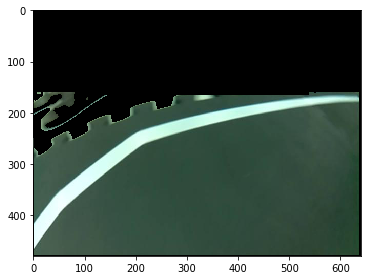

In [12]:
image = imread('./dataset/lane/170.jpg')
frame = cv2.resize(image,(640, 480))
gray=cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
height=image.shape[0]
width=image.shape[1]
region_of_interest_vertices = [   
    (0, height),
    (0, (height/3)),
#     ((width/5), (height/3)),

#     (width-(width/5), (height/3)),
    (width, (height/3)),
    (width, height)]


lowerB=np.array([50,50,50])
upperB=np.array([170,170,170])    
maskB = cv2.inRange(image, lowerB, upperB)

cropped_image = region_of_interest(maskB,np.array([region_of_interest_vertices], np.int32))
cropped_image[int(height/3):int(height/3)+5,100:width-101]=255
cropped_image[height-1,:]=255
cropped_image[250:,0]=255
cropped_image[:,width-3:]=255

binary = np.array(ndi.binary_fill_holes(cropped_image))*255
binary[int(height/3):int(height/3)+5,100:width-101]=0
binary[height-1,:]=0
binary[300:,0]=0
binary[:,width-3:]=0

img2 = np.zeros_like(image)
img2[:,:,0] = binary
img2[:,:,1] = binary
img2[:,:,2] = binary
maskBB = cv2.bitwise_and(image, img2)

# color range
lowerY=np.array([200,200,0])
upperY=np.array([255,255,204])    
maskY = cv2.inRange(maskBB, lowerY, upperY)
# maskY = dilation(maskY, square(5))
# maskY = np.array(ndi.binary_fill_holes(maskY), dtype=np.uint8)*255

lowerW=np.array([170,200,200])
upperW=np.array([255,255,255])    
maskW = cv2.inRange(maskBB, lowerW, upperW)

lowerR=np.array([220,70,70])
upperR=np.array([255,160,170])    
maskR = cv2.inRange(maskBB, lowerR, upperR)

mask = maskY+maskW+maskR
mask = dilation(mask, square(5))


imshow(maskBB)
# for i in range(16): 
#     start=30*i
#     end=30*(i+1)
#     if(findWhitePixel(mask,start,left) and findWhitePixel(mask,end,left)):
#         frame = cv2.line(cropped_image, 
#                          findWhitePixel(mask,start,left), 
#                          findWhitePixel(mask,end,left), 
#                          color, 
#                          thickness) 
#         slopeLeft = slope(findWhitePixel(mask,start,left), findWhitePixel(mask,end,left),width)
#     if(findWhitePixel(mask,start,right) and findWhitePixel(mask,end,right)):
#         frame = cv2.line(cropped_image, 
#                          findWhitePixel(mask,start,right), 
#                          findWhitePixel(mask,end,right),
#                          color, 
#                          thickness)
#         slopeRight = slope(findWhitePixel(mask,start,right), findWhitePixel(mask,end,right),width)
#     if(slopeLeft and slopeRight):
#         print('slope',slopeLeft,slopeRight)
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         cv2.putText(frame,'',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
#         if(slopeLeft>0):
#             if(slopeRight<0):

#                 cv2.putText(frame,'forward',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
#             else:
#                 cv2.putText(frame,'right',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)                    
#         else:
#             if(slopeRight<0):
#                 cv2.putText(frame,'left',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
#             else:
#                 cv2.putText(frame,'error',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
# print(mask)


In [42]:
a=np.zeros((100,100)).astype(int)

In [43]:
a[2:,0]=1

In [44]:
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])